<a href="https://colab.research.google.com/github/giozu/FEniCS/blob/main/1D/1d_diffusion_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion equation

In this notebook, we will solve the 1D diffusion equation with FEniCS:

\begin{alignat}{2}
\frac{\partial u}{\partial t} &= D \nabla^2 u + f \quad && \text{ in } \Omega \\
u &= u_{\mathrm{D}} \quad && \text{ on } \Gamma_{\mathrm{D}} \\
u &= g(x) \quad && \text{ at } t=0 \\
\end{alignat}

We will use the following data:

* $\Omega = [0,1]$
* $f(x, y) = 1$
* $D = 1$
* $u_{\mathrm{D}} = 0$
* $t \in (0,1)$
* $g(x) = \sin(\pi x)$

## Importing FEniCS
The first thing we need to do is to import FEniCS. We will also need to import the meshing library `mshr`.

In [ ]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

import fenics as fe
import matplotlib.pyplot as plt

## Initializing notebook plotting
When running in a Jupyter notebook, a special line is necessary to show FEniCS plots in the notebook.

In [ ]:
%matplotlib inline

## Creating the mesh
To create the mesh, a simple FEniCS function is adopted

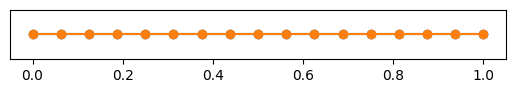

In [ ]:
n_elements = 16
mesh = fe.UnitIntervalMesh(n_elements)
fe.plot(mesh)

fe.plot(mesh)

## Defining the finite element function space
When we have created the mesh, we can define the finite element function space. We will use a standard piecewise linear $P_1$ (Lagrangian) function space.

In [ ]:
# Function space
lagrange_polynomial_space_first_order = fe.FunctionSpace(
    mesh,
    "Lagrange",
    1
)

## Defining the boundary condition
The boundary condition can be defined by specifying all points on the boundary closer to either of the two circle centers than a distance slightly larger than the radius $r = 0.25$. 

In [ ]:
def boundary_function(x, on_boundary):
  return on_boundary

# Boundary condition
boundary_condition = fe.DirichletBC(
    lagrange_polynomial_space_first_order,
    fe.Constant(0.0),
    boundary_function,
)

## Defining the initial condition
The initial condition can be imposed with a specific instruction.

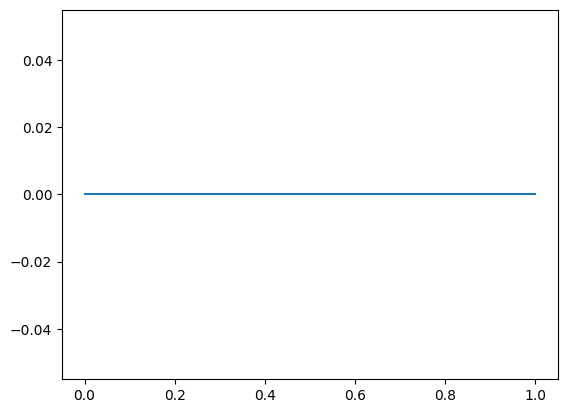

In [ ]:
# Initial condition
# initial_condition_expression = fe.Expression(
#     "sin(3.141 * x[0])",
#     degree = 1,
# )

initial_condition_expression = fe.Constant(0.0)

u_old = fe.interpolate(
    initial_condition_expression,
    lagrange_polynomial_space_first_order
)

plt.figure()
fe.plot(u_old, label="t=0.0")

## Defining the variational problem
The finite element variational problem  reads: Find $u \in V$ such that
$$
\int_{\Omega} u^{t+1} v \,\mathrm{d} x - \int_{\Omega} u^{t} v \,\mathrm{d}x + \int_{\Omega} D \Delta t (\nabla u^{t+1} \cdot \nabla v) \,\mathrm{d}x = \int_{\Omega} fv \,\mathrm{d}x
$$
for all $v \in V$.

This can be expressed in FEniCS by defining the *bilinear form* $a$ and the *linear form* $L$:

\begin{align}
  a(u, v) &= \int_{\Omega} \nabla u \cdot \nabla v \,\mathrm{d}x, \\
  L(v) &= \int_{\Omega} fv \,\mathrm{d}x.
\end{align}

In [ ]:
time_step = 0.1
diffusivity = 1.0

# The forcing on the rhs of the PDE
source = fe.Constant(1.0)

# Weak formulation
u_trial = fe.TrialFunction(lagrange_polynomial_space_first_order)
v_test = fe.TestFunction(lagrange_polynomial_space_first_order)

weak_form = (
    u_trial * v_test * fe.dx - 
    u_old * v_test * fe.dx +
    time_step * diffusivity * fe.inner(fe.grad(u_trial), fe.grad(v_test)) * fe.dx -
    time_step * source * v_test * fe.dx
)

weak_form_lhs = fe.lhs(weak_form)
weak_form_rhs = fe.rhs(weak_form)

u_solution = fe.Function(lagrange_polynomial_space_first_order)

## Solving the variational problem
The variational problem can now be solved by calling the FEniCS `solve` command wuthin a temporal loop. Use the `plot` command to visualize the solution. 

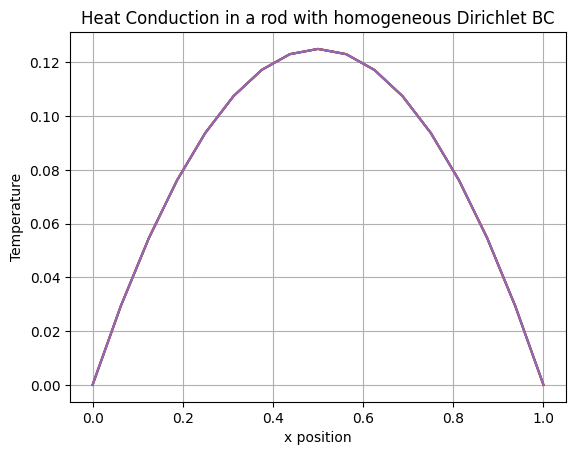

In [ ]:
# Time iteration
time_current = 0.0
for t in range(5):
  time_current += time_step

  fe.solve(
      weak_form_lhs == weak_form_rhs,
      u_solution,
      boundary_condition,
  )

  u_old.assign(u_solution)

  fe.plot(u_solution, label = f"t={time_current:1.1f}")

# plt.legend()
plt.title("Heat Conduction in a rod with homogeneous Dirichlet BC")
plt.xlabel("x position")
plt.ylabel("Temperature")
plt.grid()
plt.show()